In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import time
import datetime
from numpy import nan
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import collections

%matplotlib inline
from matplotlib.pylab import rcParams

# function to read the csv file

In [2]:
def create_dataframe(filepath):
    test = pd.read_csv(filepath) # here the given csv file is reading
    return test
filepath = '/home/atif/dataset_26_april_3.csv'
# filepath = 'E:/University of Bremen MSc/masters_thesis/IAT_sebastian/dataset_26_april_3.csv'
initial_dataframe = create_dataframe(filepath)

# In this cell dateTime column will be made but will not set it up as index column

In [3]:
# function for converting timestamp to unixtime and return the ready dataframe

def conversion_timestamp_to_unixtime(initial_dataframe):
    ''' now conversion of timestamp to unixtime will start. In the csv file the column name of
    timestamp is longtime.'''
    
    longTime = initial_dataframe.loc[0:,['longTime']]
    longTime = longTime.as_matrix()
    a = []
    date_time_array = []
    for k in longTime:
        a = np.append(a,k)
    str_time = []
    correct_longtime = []
    datetime_time = []
    count = 0
    
    for b in a:
        b = int(b) # make plain integer
        str_b = str(b)
        c = str_b[-3:]
        new_str_b = str_b.replace(c, '',1)
        new_str_b_time = int(new_str_b)
        correct_longtime.append(new_str_b_time)
        now_time = datetime.datetime.fromtimestamp(new_str_b_time)
        convert_time = now_time.strftime('%Y-%m-%d %H:%M')
        str_time.append(convert_time)
    test_new = initial_dataframe.assign(stringTime=str_time,correct_longtime=correct_longtime) # here new column in the panda dataframe for string_time has added
    test_new['dateTime'] =  pd.to_datetime(test_new['stringTime'], format='%Y-%m-%d %H:%M')
    test_new = test_new.drop(['longTime','stringTime','correct_longtime'], axis=1)
    
    return test_new

test_new = conversion_timestamp_to_unixtime(initial_dataframe)

/home/atif/iai_ml_venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [4]:
test_new.head()

,row ID,AEAGHOAWE2T1,AEAGHOAWE2A0,AEAGHOAWE2T0,AEAGHOAWE1A0,AEAGHOAWE1T1,AEAGHOAWE1T0,AEAGHOAWE3T0,AEAGHOAWE3A0,AEAGHOAWE3T1,...,RWWIHOT7_RV0,RWWIHOT8_RV0,RWWIHOT9_RV0,RWWIHOT10RV0,RWWIHOTSURV0,RWWIHOTSUMV0,RWWIHO_VERV0,RWWIHO_UESV0,RWWIHOSUMAV0,dateTime
0,Row0,74.451979,19.111606,98.371549,18.819155,93.337524,69.969526,95.445534,7.802471,57.766387,...,92.632593,44.620461,22.338103,75.685755,73.945394,0.000000,0.000000,0.000000,0.000000,2019-04-15 08:52:00
1,Row1,73.933103,18.088026,98.186038,18.943335,92.869960,69.969526,95.445534,12.856953,58.231774,...,82.082055,53.182296,26.967692,75.685755,66.649583,56.385432,68.734584,9.127668,2.275890,2019-04-15 08:51:00
2,Row2,73.471742,25.843589,98.371549,33.166077,92.343799,69.969526,95.628479,21.591973,58.231774,...,82.098144,53.029243,26.851837,75.685755,66.587330,56.402658,68.853203,9.136596,2.275735,2019-04-15 08:50:00
3,Row3,73.010381,27.772137,98.371549,35.991205,91.876236,69.850105,95.607810,19.492370,58.231774,...,82.074011,53.015226,26.266369,75.685755,66.373907,56.527297,69.391059,9.138625,2.281882,2019-04-15 08:49:00
4,Row4,72.549020,18.402556,98.186038,19.591687,91.408672,69.969526,95.607810,8.014898,58.697162,...,82.078296,53.172932,26.605640,75.685755,66.529224,56.640964,69.299560,9.121256,2.269317,2019-04-15 08:48:00


# look here in the previous cell if test.head() is printed then 'row ID' column will be appeared which is problematic. so, remove it.

In [5]:
test_new_1 = test_new.drop(['row ID'], axis = 1)

In [6]:
test_new_1.head()

,AEAGHOAWE2T1,AEAGHOAWE2A0,AEAGHOAWE2T0,AEAGHOAWE1A0,AEAGHOAWE1T1,AEAGHOAWE1T0,AEAGHOAWE3T0,AEAGHOAWE3A0,AEAGHOAWE3T1,AEAGHOAWE_A2,...,RWWIHOT7_RV0,RWWIHOT8_RV0,RWWIHOT9_RV0,RWWIHOT10RV0,RWWIHOTSURV0,RWWIHOTSUMV0,RWWIHO_VERV0,RWWIHO_UESV0,RWWIHOSUMAV0,dateTime
0,74.451979,19.111606,98.371549,18.819155,93.337524,69.969526,95.445534,7.802471,57.766387,99.791538,...,92.632593,44.620461,22.338103,75.685755,73.945394,0.000000,0.000000,0.000000,0.000000,2019-04-15 08:52:00
1,73.933103,18.088026,98.186038,18.943335,92.869960,69.969526,95.445534,12.856953,58.231774,99.791538,...,82.082055,53.182296,26.967692,75.685755,66.649583,56.385432,68.734584,9.127668,2.275890,2019-04-15 08:51:00
2,73.471742,25.843589,98.371549,33.166077,92.343799,69.969526,95.628479,21.591973,58.231774,79.907849,...,82.098144,53.029243,26.851837,75.685755,66.587330,56.402658,68.853203,9.136596,2.275735,2019-04-15 08:50:00
3,73.010381,27.772137,98.371549,35.991205,91.876236,69.850105,95.607810,19.492370,58.231774,94.169116,...,82.074011,53.015226,26.266369,75.685755,66.373907,56.527297,69.391059,9.138625,2.281882,2019-04-15 08:49:00
4,72.549020,18.402556,98.186038,19.591687,91.408672,69.969526,95.607810,8.014898,58.697162,100.000000,...,82.078296,53.172932,26.605640,75.685755,66.529224,56.640964,69.299560,9.121256,2.269317,2019-04-15 08:48:00


In [7]:
print(test_new.shape)
print(test_new_1.shape)

(25000, 4220)
(25000, 4219)


In [8]:
a = test_new.reset_index()
b = test_new_1.reset_index()

In [9]:
print(a.shape)
print(b.shape)

(25000, 4221)
(25000, 4220)


In [10]:
a.head()

,index,row ID,AEAGHOAWE2T1,AEAGHOAWE2A0,AEAGHOAWE2T0,AEAGHOAWE1A0,AEAGHOAWE1T1,AEAGHOAWE1T0,AEAGHOAWE3T0,AEAGHOAWE3A0,...,RWWIHOT7_RV0,RWWIHOT8_RV0,RWWIHOT9_RV0,RWWIHOT10RV0,RWWIHOTSURV0,RWWIHOTSUMV0,RWWIHO_VERV0,RWWIHO_UESV0,RWWIHOSUMAV0,dateTime
0,0,Row0,74.451979,19.111606,98.371549,18.819155,93.337524,69.969526,95.445534,7.802471,...,92.632593,44.620461,22.338103,75.685755,73.945394,0.000000,0.000000,0.000000,0.000000,2019-04-15 08:52:00
1,1,Row1,73.933103,18.088026,98.186038,18.943335,92.869960,69.969526,95.445534,12.856953,...,82.082055,53.182296,26.967692,75.685755,66.649583,56.385432,68.734584,9.127668,2.275890,2019-04-15 08:51:00
2,2,Row2,73.471742,25.843589,98.371549,33.166077,92.343799,69.969526,95.628479,21.591973,...,82.098144,53.029243,26.851837,75.685755,66.587330,56.402658,68.853203,9.136596,2.275735,2019-04-15 08:50:00
3,3,Row3,73.010381,27.772137,98.371549,35.991205,91.876236,69.850105,95.607810,19.492370,...,82.074011,53.015226,26.266369,75.685755,66.373907,56.527297,69.391059,9.138625,2.281882,2019-04-15 08:49:00
4,4,Row4,72.549020,18.402556,98.186038,19.591687,91.408672,69.969526,95.607810,8.014898,...,82.078296,53.172932,26.605640,75.685755,66.529224,56.640964,69.299560,9.121256,2.269317,2019-04-15 08:48:00


In [11]:
b.head()

,index,AEAGHOAWE2T1,AEAGHOAWE2A0,AEAGHOAWE2T0,AEAGHOAWE1A0,AEAGHOAWE1T1,AEAGHOAWE1T0,AEAGHOAWE3T0,AEAGHOAWE3A0,AEAGHOAWE3T1,...,RWWIHOT7_RV0,RWWIHOT8_RV0,RWWIHOT9_RV0,RWWIHOT10RV0,RWWIHOTSURV0,RWWIHOTSUMV0,RWWIHO_VERV0,RWWIHO_UESV0,RWWIHOSUMAV0,dateTime
0,0,74.451979,19.111606,98.371549,18.819155,93.337524,69.969526,95.445534,7.802471,57.766387,...,92.632593,44.620461,22.338103,75.685755,73.945394,0.000000,0.000000,0.000000,0.000000,2019-04-15 08:52:00
1,1,73.933103,18.088026,98.186038,18.943335,92.869960,69.969526,95.445534,12.856953,58.231774,...,82.082055,53.182296,26.967692,75.685755,66.649583,56.385432,68.734584,9.127668,2.275890,2019-04-15 08:51:00
2,2,73.471742,25.843589,98.371549,33.166077,92.343799,69.969526,95.628479,21.591973,58.231774,...,82.098144,53.029243,26.851837,75.685755,66.587330,56.402658,68.853203,9.136596,2.275735,2019-04-15 08:50:00
3,3,73.010381,27.772137,98.371549,35.991205,91.876236,69.850105,95.607810,19.492370,58.231774,...,82.074011,53.015226,26.266369,75.685755,66.373907,56.527297,69.391059,9.138625,2.281882,2019-04-15 08:49:00
4,4,72.549020,18.402556,98.186038,19.591687,91.408672,69.969526,95.607810,8.014898,58.697162,...,82.078296,53.172932,26.605640,75.685755,66.529224,56.640964,69.299560,9.121256,2.269317,2019-04-15 08:48:00


# be careful here , when perform on a dataframe reset_index then a new column will appear and it is 'index'. No need of it so immediately drop it. for better view please take a look in the previous cell

# Now it's time to alter the dataframe. This will oreder the dataframe in ascending prder with respect to dateTime

In [12]:
# here using test_new_1 as it has no row ID column and also no problematic value

def alter_time(dataframe, start_pos, end_pos):
#     multivariate_data=test_new.iloc[start_pos:end_pos][multivariate_column_label] # comment out this line if you pass column label
    dataframe=dataframe.iloc[start_pos:end_pos][:]
    dataframe=dataframe.loc[::-1]
    
    return dataframe

start_pos = 0
end_pos = 25000
multivariate_data = alter_time(test_new_1, start_pos, end_pos)
multivariate_data.head()

,AEAGHOAWE2T1,AEAGHOAWE2A0,AEAGHOAWE2T0,AEAGHOAWE1A0,AEAGHOAWE1T1,AEAGHOAWE1T0,AEAGHOAWE3T0,AEAGHOAWE3A0,AEAGHOAWE3T1,AEAGHOAWE_A2,...,RWWIHOT7_RV0,RWWIHOT8_RV0,RWWIHOT9_RV0,RWWIHOT10RV0,RWWIHOTSURV0,RWWIHOTSUMV0,RWWIHO_VERV0,RWWIHO_UESV0,RWWIHOSUMAV0,dateTime
24999,72.030143,21.542766,94.083085,22.656925,82.875638,67.650387,95.811415,11.299942,60.849423,100.000000,...,92.507129,44.620461,28.127074,82.825607,78.104338,67.050713,75.017129,0.385938,5.503583,2019-03-11 03:14:00
24998,72.491504,26.431470,94.083085,27.250685,82.875638,67.530966,95.648382,15.316148,60.849423,83.088535,...,92.521725,44.620461,30.234661,82.718776,78.744878,67.904313,74.995147,0.391870,5.464381,2019-03-11 03:15:00
24997,72.952865,16.340439,94.083085,9.402699,83.810765,67.501116,95.648382,7.900882,60.384036,95.667996,...,92.484799,44.620461,33.680038,82.812397,79.820670,69.482925,75.118191,0.391758,5.461172,2019-03-11 03:16:00
24996,73.414226,25.111296,94.247637,20.460754,84.336621,67.501116,95.648382,8.682349,60.384036,93.447307,...,92.458005,44.620461,36.388113,82.644399,80.584952,69.763910,74.112424,0.396539,5.446945,2019-03-11 03:17:00
24995,73.875587,26.183628,94.247637,26.243646,84.862783,67.635740,95.486096,16.656556,60.384036,76.483634,...,92.467179,44.620461,35.372044,82.999752,80.398505,69.927938,74.680827,0.390438,5.434438,2019-03-11 03:18:00


# Now target column and dateTime colum will be arranged as a given column index. Here target column is the output of turbine 9's output

In [13]:
def rearrange_frame(dataframe,colname,col_pos):
    
    list_col=dataframe.columns.to_list()
    temp_list=list_col
    for idx,i in enumerate(colname):
        sacrifice_val = temp_list[col_pos[idx]]        
        indx=dataframe.columns.get_loc(i)
        temp_list[col_pos[idx]]=i
        temp_list[indx]=sacrifice_val
        
    return dataframe.iloc[:][temp_list]
index_array=[0,-1]
req_column_name = ['dateTime','AEWIHO_T9AV2']
rearranged_dataframe = rearrange_frame(multivariate_data,req_column_name,index_array)
rearranged_dataframe.head()

,dateTime,AEAGHOAWE2A0,AEAGHOAWE2T0,AEAGHOAWE1A0,AEAGHOAWE1T1,AEAGHOAWE1T0,AEAGHOAWE3T0,AEAGHOAWE3A0,AEAGHOAWE3T1,AEAGHOAWE_A2,...,RWWIHOT7_RV0,RWWIHOT8_RV0,RWWIHOT9_RV0,RWWIHOT10RV0,RWWIHOTSURV0,RWWIHOTSUMV0,RWWIHO_VERV0,RWWIHO_UESV0,RWWIHOSUMAV0,AEWIHO_T9AV2
24999,2019-03-11 03:14:00,21.542766,94.083085,22.656925,82.875638,67.650387,95.811415,11.299942,60.849423,100.000000,...,92.507129,44.620461,28.127074,82.825607,78.104338,67.050713,75.017129,0.385938,5.503583,79.178306
24998,2019-03-11 03:15:00,26.431470,94.083085,27.250685,82.875638,67.530966,95.648382,15.316148,60.849423,83.088535,...,92.521725,44.620461,30.234661,82.718776,78.744878,67.904313,74.995147,0.391870,5.464381,81.659117
24997,2019-03-11 03:16:00,16.340439,94.083085,9.402699,83.810765,67.501116,95.648382,7.900882,60.384036,95.667996,...,92.484799,44.620461,33.680038,82.812397,79.820670,69.482925,75.118191,0.391758,5.461172,86.055430
24996,2019-03-11 03:17:00,25.111296,94.247637,20.460754,84.336621,67.501116,95.648382,8.682349,60.384036,93.447307,...,92.458005,44.620461,36.388113,82.644399,80.584952,69.763910,74.112424,0.396539,5.446945,87.113691
24995,2019-03-11 03:18:00,26.183628,94.247637,26.243646,84.862783,67.635740,95.486096,16.656556,60.384036,76.483634,...,92.467179,44.620461,35.372044,82.999752,80.398505,69.927938,74.680827,0.390438,5.434438,87.266264


In [14]:
print(multivariate_data.shape)
print(rearranged_dataframe.shape)

(25000, 4219)
(25000, 4219)


# Now take in consideration the signal DEWIHOBT9_I0. When the value of it's will be 100 only then target column will work otherwise not. So, choose this signal and drop all of the rows where it's value != 100 and then drop the whole colum as after dropping this column will only contain value 100 and it will affect negatively in the correlation with target signal

In [15]:
# the function will do the following task
# if the blast furnace signal for turbine 9 is zero then no work will be happened.
# so, remove all the rows where this value will be zero

def drop_zero_value_row_of_blast_furnace_signal(dataframe, blast_furnace_signal):
#     dataframe = dataframe.reset_index()
    count = []
    print(blast_furnace_signal)
    for idx_blast_furnace, val_blast_furnace in enumerate(dataframe[blast_furnace_signal]):
        if val_blast_furnace != 100 :
            count = np.append(count,idx_blast_furnace)
    print('size of count array here: ', count.size)
    
    if count.size > 0:
        dataframe_1 = dataframe.drop(count,axis=0) # axis= 0 means row indiated. 1 means column indicated
    else:
        dataframe_1 = dataframe
    dataframe_1 = dataframe_1.drop([blast_furnace_signal], axis=1) # dropping the column. because all value are same   
    return dataframe_1
blast_furnace_signal = 'DEWIHOBT9_I0'

dataframe_no_zero_value_blast_furnace = drop_zero_value_row_of_blast_furnace_signal(rearranged_dataframe,blast_furnace_signal)

DEWIHOBT9_I0
size of count array here:  760


In [16]:
dataframe_no_zero_value_blast_furnace.head()

,dateTime,AEAGHOAWE2A0,AEAGHOAWE2T0,AEAGHOAWE1A0,AEAGHOAWE1T1,AEAGHOAWE1T0,AEAGHOAWE3T0,AEAGHOAWE3A0,AEAGHOAWE3T1,AEAGHOAWE_A2,...,RWWIHOT7_RV0,RWWIHOT8_RV0,RWWIHOT9_RV0,RWWIHOT10RV0,RWWIHOTSURV0,RWWIHOTSUMV0,RWWIHO_VERV0,RWWIHO_UESV0,RWWIHOSUMAV0,AEWIHO_T9AV2
24999,2019-03-11 03:14:00,21.542766,94.083085,22.656925,82.875638,67.650387,95.811415,11.299942,60.849423,100.000000,...,92.507129,44.620461,28.127074,82.825607,78.104338,67.050713,75.017129,0.385938,5.503583,79.178306
24998,2019-03-11 03:15:00,26.431470,94.083085,27.250685,82.875638,67.530966,95.648382,15.316148,60.849423,83.088535,...,92.521725,44.620461,30.234661,82.718776,78.744878,67.904313,74.995147,0.391870,5.464381,81.659117
24997,2019-03-11 03:16:00,16.340439,94.083085,9.402699,83.810765,67.501116,95.648382,7.900882,60.384036,95.667996,...,92.484799,44.620461,33.680038,82.812397,79.820670,69.482925,75.118191,0.391758,5.461172,86.055430
24996,2019-03-11 03:17:00,25.111296,94.247637,20.460754,84.336621,67.501116,95.648382,8.682349,60.384036,93.447307,...,92.458005,44.620461,36.388113,82.644399,80.584952,69.763910,74.112424,0.396539,5.446945,87.113691
24995,2019-03-11 03:18:00,26.183628,94.247637,26.243646,84.862783,67.635740,95.486096,16.656556,60.384036,76.483634,...,92.467179,44.620461,35.372044,82.999752,80.398505,69.927938,74.680827,0.390438,5.434438,87.266264


In [17]:
print(rearranged_dataframe.shape)
print(dataframe_no_zero_value_blast_furnace.shape)

(25000, 4219)
(24240, 4218)


# Now choose the target colum  and check if any value is zero or not. If zero then drop those rows. here taret column is T9's output, signal name is AEWIHO_T9AV2

In [18]:
def drop_zero_value_row_of_target_signal(dataframe, target_signal):
    count = []
    for idx_blast_furnace, val_blast_furnace in enumerate(dataframe[target_signal]):
        if val_blast_furnace == 0 :
            count = np.append(count,idx_blast_furnace)

    for i in count:
        if i > 24222:
            print(i)
    print('size of count array: ', count.size)

    if count.size > 0:
        dataframe_1 = dataframe.drop(count,axis=0) # axis= 0 means row indiated. 1 means column indicated
    else:
        dataframe_1 = dataframe
    dataframe_1 = dataframe_1.drop(dataframe_1.columns[0], axis = 1) # generally after resetting index the former index 
                                                                                            # take place the first place of the column. so removing it.
    return dataframe_1


target_signal = 'AEWIHO_T9AV2'
dataframe_reset = dataframe_no_zero_value_blast_furnace.reset_index()
dataframe_no_zero_value_target_column = drop_zero_value_row_of_target_signal(dataframe_reset,target_signal)

24223.0
24224.0
24231.0
size of count array:  110


In [19]:
dataframe_no_zero_value_target_column.head()

,dateTime,AEAGHOAWE2A0,AEAGHOAWE2T0,AEAGHOAWE1A0,AEAGHOAWE1T1,AEAGHOAWE1T0,AEAGHOAWE3T0,AEAGHOAWE3A0,AEAGHOAWE3T1,AEAGHOAWE_A2,...,RWWIHOT7_RV0,RWWIHOT8_RV0,RWWIHOT9_RV0,RWWIHOT10RV0,RWWIHOTSURV0,RWWIHOTSUMV0,RWWIHO_VERV0,RWWIHO_UESV0,RWWIHOSUMAV0,AEWIHO_T9AV2
0,2019-03-11 03:14:00,21.542766,94.083085,22.656925,82.875638,67.650387,95.811415,11.299942,60.849423,100.000000,...,92.507129,44.620461,28.127074,82.825607,78.104338,67.050713,75.017129,0.385938,5.503583,79.178306
1,2019-03-11 03:15:00,26.431470,94.083085,27.250685,82.875638,67.530966,95.648382,15.316148,60.849423,83.088535,...,92.521725,44.620461,30.234661,82.718776,78.744878,67.904313,74.995147,0.391870,5.464381,81.659117
2,2019-03-11 03:16:00,16.340439,94.083085,9.402699,83.810765,67.501116,95.648382,7.900882,60.384036,95.667996,...,92.484799,44.620461,33.680038,82.812397,79.820670,69.482925,75.118191,0.391758,5.461172,86.055430
3,2019-03-11 03:17:00,25.111296,94.247637,20.460754,84.336621,67.501116,95.648382,8.682349,60.384036,93.447307,...,92.458005,44.620461,36.388113,82.644399,80.584952,69.763910,74.112424,0.396539,5.446945,87.113691
4,2019-03-11 03:18:00,26.183628,94.247637,26.243646,84.862783,67.635740,95.486096,16.656556,60.384036,76.483634,...,92.467179,44.620461,35.372044,82.999752,80.398505,69.927938,74.680827,0.390438,5.434438,87.266264


In [20]:
print(dataframe_no_zero_value_blast_furnace.shape)
print(dataframe_no_zero_value_target_column.shape)

(24240, 4218)
(24130, 4218)


# Now drop all columns whose all vaues are same

In [21]:
def drop_column_with_same_value(dataframe):
    cols = dataframe.select_dtypes([np.number]).columns
    diff = dataframe[cols].diff().sum()
    dataframe_drop_column_with_same_value = dataframe.drop(diff[diff== 0].index, axis=1)
    
    return dataframe_drop_column_with_same_value

dataframe_drop_column_with_same_value = drop_column_with_same_value(dataframe_no_zero_value_target_column)

In [22]:
dataframe_drop_column_with_same_value.head()

,dateTime,AEAGHOAWE2A0,AEAGHOAWE2T0,AEAGHOAWE1A0,AEAGHOAWE1T1,AEAGHOAWE1T0,AEAGHOAWE3T0,AEAGHOAWE3A0,AEAGHOAWE3T1,AEAGHOAWE_A2,...,RWWIHOUT10V0,RWWIHOT7_RV0,RWWIHOT9_RV0,RWWIHOT10RV0,RWWIHOTSURV0,RWWIHOTSUMV0,RWWIHO_VERV0,RWWIHO_UESV0,RWWIHOSUMAV0,AEWIHO_T9AV2
0,2019-03-11 03:14:00,21.542766,94.083085,22.656925,82.875638,67.650387,95.811415,11.299942,60.849423,100.000000,...,0.182275,92.507129,28.127074,82.825607,78.104338,67.050713,75.017129,0.385938,5.503583,79.178306
1,2019-03-11 03:15:00,26.431470,94.083085,27.250685,82.875638,67.530966,95.648382,15.316148,60.849423,83.088535,...,0.182267,92.521725,30.234661,82.718776,78.744878,67.904313,74.995147,0.391870,5.464381,81.659117
2,2019-03-11 03:16:00,16.340439,94.083085,9.402699,83.810765,67.501116,95.648382,7.900882,60.384036,95.667996,...,0.182262,92.484799,33.680038,82.812397,79.820670,69.482925,75.118191,0.391758,5.461172,86.055430
3,2019-03-11 03:17:00,25.111296,94.247637,20.460754,84.336621,67.501116,95.648382,8.682349,60.384036,93.447307,...,0.182227,92.458005,36.388113,82.644399,80.584952,69.763910,74.112424,0.396539,5.446945,87.113691
4,2019-03-11 03:18:00,26.183628,94.247637,26.243646,84.862783,67.635740,95.486096,16.656556,60.384036,76.483634,...,0.182184,92.467179,35.372044,82.999752,80.398505,69.927938,74.680827,0.390438,5.434438,87.266264


In [23]:
print(dataframe_no_zero_value_target_column.shape)
print(dataframe_drop_column_with_same_value.shape)

(24130, 4218)
(24130, 2109)


# check on the whole dataframe if there is any NAN value or not. If YES, replace it with zero and drop

In [24]:
# Think twice before using this function
# checking if any column has nan value or not. If YES then replace nan with zero and drop the row

# a = dataframe_no_zero_value_blast_furnace[blast_furnace_signal].isnull().sum()
# print(a)

def drop_nan_value(dataframe):
    for index,column in enumerate(dataframe):
        nan_catcher = dataframe[column].isnull().sum()
        if nan_catcher !=0:
            dataframe_1 = dataframe[column].replace(0,nan)
            dataframe_1 = dataframe.dropna(how='any',axis=0)
#             print(column,' has total',nan_catcher, 'nan valu')
        else:
            dataframe_1 = dataframe
#             print(column,' is free from nan value. look it has: ', nan_catcher,' value')
            
    return dataframe_1

multivariate_data_drop_nan = drop_nan_value(dataframe_drop_column_with_same_value)

In [25]:
multivariate_data_drop_nan.head()

,dateTime,AEAGHOAWE2A0,AEAGHOAWE2T0,AEAGHOAWE1A0,AEAGHOAWE1T1,AEAGHOAWE1T0,AEAGHOAWE3T0,AEAGHOAWE3A0,AEAGHOAWE3T1,AEAGHOAWE_A2,...,RWWIHOUT10V0,RWWIHOT7_RV0,RWWIHOT9_RV0,RWWIHOT10RV0,RWWIHOTSURV0,RWWIHOTSUMV0,RWWIHO_VERV0,RWWIHO_UESV0,RWWIHOSUMAV0,AEWIHO_T9AV2
0,2019-03-11 03:14:00,21.542766,94.083085,22.656925,82.875638,67.650387,95.811415,11.299942,60.849423,100.000000,...,0.182275,92.507129,28.127074,82.825607,78.104338,67.050713,75.017129,0.385938,5.503583,79.178306
1,2019-03-11 03:15:00,26.431470,94.083085,27.250685,82.875638,67.530966,95.648382,15.316148,60.849423,83.088535,...,0.182267,92.521725,30.234661,82.718776,78.744878,67.904313,74.995147,0.391870,5.464381,81.659117
2,2019-03-11 03:16:00,16.340439,94.083085,9.402699,83.810765,67.501116,95.648382,7.900882,60.384036,95.667996,...,0.182262,92.484799,33.680038,82.812397,79.820670,69.482925,75.118191,0.391758,5.461172,86.055430
3,2019-03-11 03:17:00,25.111296,94.247637,20.460754,84.336621,67.501116,95.648382,8.682349,60.384036,93.447307,...,0.182227,92.458005,36.388113,82.644399,80.584952,69.763910,74.112424,0.396539,5.446945,87.113691
4,2019-03-11 03:18:00,26.183628,94.247637,26.243646,84.862783,67.635740,95.486096,16.656556,60.384036,76.483634,...,0.182184,92.467179,35.372044,82.999752,80.398505,69.927938,74.680827,0.390438,5.434438,87.266264


In [26]:
def drop_row(dataframe):
    
    for i in dataframe:
#         print(i)
        dataframe_drop_row_consecutive_same_value = dataframe.loc[dataframe[i].shift() != dataframe[i]]
    
    return dataframe_drop_row_consecutive_same_value

dataframe_drop_row_consecutive_same_value = drop_row(multivariate_data_drop_nan)

In [27]:
def drop_string_column(dataframe):
    drop_object = dataframe.select_dtypes(exclude=['object'])
    
    return drop_object

dataframe_no_string = drop_string_column(dataframe_drop_row_consecutive_same_value)

In [28]:
print(multivariate_data_drop_nan.shape)
print(dataframe_drop_row_consecutive_same_value.shape)
print(dataframe_no_string.shape)

(24130, 2109)
(24108, 2109)
(24108, 2109)


# All data cleaning process has done. Now feature selection process will come. Before doing this just make a copy of dataframe and set the index as dateTime

In [29]:
dataframe_copy = dataframe_no_string.copy()

In [30]:
dataframe_datetime = dataframe_copy.set_index('dateTime')

In [31]:
print(dataframe_copy.shape)
print(dataframe_datetime.shape)

(24108, 2109)
(24108, 2108)


# Sklearn feature selection function

In [32]:
def feature_selection_with_selectKbest(dataframe,max_best_number):
    train_input = dataframe.iloc[:,:-1]
    train_output = dataframe.iloc[:,-1]
    train_output = train_output.to_frame()
#     train_output = pd.DataFrame(train_output)
    
    X, y = train_input, train_output
    X = X.astype(int)
    y = y.astype(int)
    
    bestfeatures = SelectKBest(score_func=chi2, k=2)
    fit = bestfeatures.fit(X,y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
#     print(featureScores.nlargest(20,'Score'))  #print 10 best features
    d = featureScores.nlargest(max_best_number,'Score')
    
    e = []
    for i,v in enumerate(d['Specs']):
        e = np.append(e,v)
    
    e = np.append(e,dataframe.columns[-1])
    final_dataframe = dataframe.iloc[:][e]
    
    return final_dataframe
max_best_number = 20
sklearn_feature_best_dataframe = feature_selection_with_selectKbest(dataframe_datetime,max_best_number)
sklearn_feature_best_dataframe.head()

,DEHGF_CHYPI2,DEHGF_C_ZGI2,DEKOSW_USCI0,AEWIHOBKF_V0,DEKDHO_T7_A0,DEKOSGG___P3,AEHGF_C___G0,AEHGHOASOKG0,RWEGTZKR1_V3,AEEGBL1_12V0,...,AEEGBCT_PEV2,AEHGF_CHF_T1,RWWIHOUT10V0,DEO2GBHRV2I4,AEKDTK_KDZN0,DEKDTK_KDZN1,AEHGF_CHF_T4,AEHGF_CHF_T2,RWHGF_C___V0,AEWIHO_T9AV2
dateTime,,,,,,,,,,,,,,,,,,,,,
2019-03-11 03:14:00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.372556,0.0,0.000195,...,0.0,0.200721,0.182275,0.0,96.847912,100.0,99.557801,0.225564,0.0,79.178306
2019-03-11 03:15:00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.372556,0.0,0.000195,...,0.0,0.200721,0.182267,0.0,96.887309,100.0,99.557801,0.225564,0.0,81.659117
2019-03-11 03:16:00,0.0,0.0,0.0,63.681313,0.0,0.0,0.0,0.372556,0.0,0.000195,...,0.0,0.199391,0.182262,0.0,96.926713,100.0,99.557801,0.225564,0.0,86.055430
2019-03-11 03:17:00,0.0,0.0,0.0,63.681313,0.0,0.0,0.0,0.372556,0.0,0.000195,...,0.0,0.203379,0.182227,0.0,96.808508,100.0,99.557801,0.225564,0.0,87.113691
2019-03-11 03:18:00,0.0,0.0,0.0,76.279499,0.0,0.0,0.0,0.372556,0.0,0.000195,...,0.0,0.200721,0.182184,0.0,96.683606,100.0,99.557801,0.225564,0.0,87.266264


In [33]:
print(dataframe_datetime.shape)
print(sklearn_feature_best_dataframe.shape)

(24108, 2108)
(24108, 21)


In [34]:
# dataframe_datetime['DEHGF_CHYPI2']

# feature selection with correlation

In [35]:
# find correlated matrix for dataframe which came from sklearn feature selection and the datafarem which has passed
# to sklearn feature selection function

def pearson_correlation(sklearn_dataframe, main_dataframe):
    sklearn_correlation = sklearn_dataframe.corr()
    main_correlation = main_dataframe.corr()
    return sklearn_correlation, main_correlation

sklearn_correlation, main_correlation = pearson_correlation(sklearn_feature_best_dataframe, dataframe_datetime)
print(sklearn_correlation.shape)
print(main_correlation.shape)

(21, 21)
(2108, 2108)


# use the correlation matrix to make the new dataframe where the feature will be the column who has a correlation value with the target in a given range. 

In [36]:
# function to make dataframe with high correlated valued column
def make_dataframe_with_high_correlated_value(main_dataframe,correlated_dataframe,
                                              correlation_threshold_value,max_value):
    
    target_column = main_dataframe.columns[-1]
    
    dataframe = correlated_dataframe.reset_index()
    
    high_correlated_array_with_target = []
    for index_corr_reset, val_corr_reset in enumerate(dataframe[target_column]):
        if val_corr_reset > correlation_threshold_value and val_corr_reset < max_value:
            required_column = dataframe.loc[index_corr_reset]['index']
            if required_column != target_column:
                high_correlated_array_with_target = np.append(high_correlated_array_with_target,required_column)
            else:
                print(required_column)
                pass
            
    final_array = np.append(high_correlated_array_with_target,target_column)
    new_dataframe = main_dataframe.iloc[:][final_array]
    
    return new_dataframe

correlation_threshold_value = 0.5
max_value = 0.9
# target_column = dataframe_datetime.columns[-1] # here declaring who is target column.


main_frame = dataframe_datetime
correlated_frame = main_correlation

# main_frame = sklearn_feature_best_dataframe
# correlated_frame = sklearn_correlation

dataframe_high_correlation = make_dataframe_with_high_correlated_value(main_frame,correlated_frame,
                                                             correlation_threshold_value,max_value)

print('dataframe_high_correlation shape: ', dataframe_high_correlation.shape)
print('dataframe_datetime shape: ', dataframe_datetime.shape)
print('correlated_frame shape: ', correlated_frame.shape)

dataframe_high_correlation shape:  (24108, 13)
dataframe_datetime shape:  (24108, 2108)
correlated_frame shape:  (2108, 2108)


In [37]:
dataframe_high_correlation.head()

,RWDAHOBG9_V0,AEDAHO_T9_V2,RWDATZ_HO_V1,RWWIHOBG9_V0,RWWIHOBK__T0,AEWIGHG9_AG1,AEWIGHG9_AG2,AEWIGHG9_AG3,AEWIGHG9__T0,AEWIHOBM__P0,AEWIHOBKF_V0,AEWIHOBK__T0,AEWIHO_T9AV2
dateTime,,,,,,,,,,,,,
2019-03-11 03:14:00,83.841293,83.327361,50.619761,79.666313,90.308474,97.229202,97.224403,96.777397,92.719615,88.893151,0.000000,90.434380,79.178306
2019-03-11 03:15:00,84.832219,84.314814,51.100140,82.313647,90.430027,97.566803,97.566803,97.113998,92.530794,88.893151,0.000000,90.434380,81.659117
2019-03-11 03:16:00,84.835578,84.380943,51.167150,86.667405,90.293459,97.566803,97.571602,97.108704,92.426648,86.467066,63.681313,89.978692,86.055430
2019-03-11 03:17:00,83.749498,83.279853,50.420753,87.678913,89.981116,97.566803,97.582703,97.112000,92.579243,86.467066,63.681313,89.978692,87.113691
2019-03-11 03:18:00,80.270870,79.963124,48.254525,87.828344,90.053752,97.563904,97.555199,97.114899,92.628148,86.467066,76.279499,90.044065,87.266264


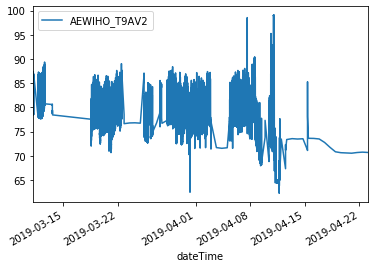

In [38]:
dataframe_datetime.iloc[0:].plot(y = dataframe_datetime.columns[-1], use_index=True)
plt.rcParams['figure.figsize'] =(15,5)

# make dataset for training

In [39]:
def make_dataset(dataframe):
    dataset = np.array(dataframe)
    NumberOfElements = int(len(dataset) * 0.98)
    print('Number of Elements for training: ', NumberOfElements)
    print('dataset length: ', len(dataset))

    train_input = dataset[0:NumberOfElements, 0:-1]
    print('train_input shape: ', train_input.shape)
    train_output = dataset[0:NumberOfElements, -1]
    print('train_output shape: ', train_output.shape)

    test_input = dataset[NumberOfElements:len(dataset), 0:-1]
    print('test_input shape: ', test_input.shape)
    test_output = dataset[NumberOfElements:len(dataset), -1]
    print('test_output shape: ', test_output.shape)

    return train_input, train_output, test_input, test_output

train_input, train_output, test_input, test_output = make_dataset(dataframe_high_correlation)

Number of Elements for training:  23625
dataset length:  24108
train_input shape:  (23625, 12)
train_output shape:  (23625,)
test_input shape:  (483, 12)
test_output shape:  (483,)


# training with different scikit learn model

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import *
from sklearn import linear_model


from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math

In [61]:
def plot_graph(test_output, predicted_output):
    plt.plot((min(test_output),max(test_output)), (min(predicted_output),max(predicted_output)), color='red')
    plt.scatter(test_output,predicted_output, color = 'blue')
    # plt.savefig(model+'_'+'figure_actual_vs_predicted_with_best_fit_line.jpg')
    plt.xlabel('test_output')
    plt.ylabel('predicted_output')
    plt.title('scatter plotting of predicted_output alongside with the average line of test and predicted output')
    plt.show()
    
    
    difference_of_value = predicted_output - test_output
    print(type(difference_of_value))

    plt.plot(difference_of_value[:])
    plt.title('observation of the difference of actual and predicted value')

# plt.rcParams['xtick.labelsize']=2
# plt.rcParams['ytick.labelsize']=2
# plt.tick_params(labelsize=20)
    plt.ylabel('difference of value')
    plt.xlabel('range')
    plt.grid(b=None, which='both', axis='both')
# plt.savefig(model+'_'+'difference_of_actual_and_predicted_value.png')
    plt.show()
    
    
    plt.hist(difference_of_value, bins=15)
# plt.xlim(-10,10,1)
# plt.savefig(model+'_'+'histogram_of_difference_value.jpg')
    plt.xlabel('value')
    plt.ylabel('frequency')
    plt.title('histogram of value of difference')
    plt.show()
    
    plt.plot(predicted_output[0:len(predicted_output[0:300])], color = 'blue')
    plt.plot(test_output[0:300], color = 'red')
# plt.xlim(0,40,1)
# plt.ylim(50,70,1)
# plt.savefig(model+'_'+'figure_difference_between_actual_and_predicted_value.jpg')
    plt.xlabel('range')
    plt.ylabel('value of test and predicted output')
    plt.title('Visualization of test and predicted output in the same timestamp')
    plt.show()

In [62]:
def scikit_learn_model(model_list, name, train_input,train_output, test_input, test_output):
    for idx, i in enumerate(model_list):
        train_model_1 = i
        print('-------', name[idx])
        train_model_1.fit(train_input, train_output)
        predicted_output = train_model_1.predict(test_input)
        
        graph = plot_graph(test_output,predicted_output)
        
        print('r_2 statistic: %.2f' % r2_score(test_output, predicted_output))
        print("Mean_absolute_error: %.2f" % mean_absolute_error(test_output, predicted_output))
        print("Mean squared error: %.2f" % mean_squared_error(test_output, predicted_output))
        RMSE = math.sqrt(mean_squared_error(test_output, predicted_output))
        print('RMSE: ', RMSE)
        print('!!!!---------------!!!!----------------!!!!')

------- LinearRegression


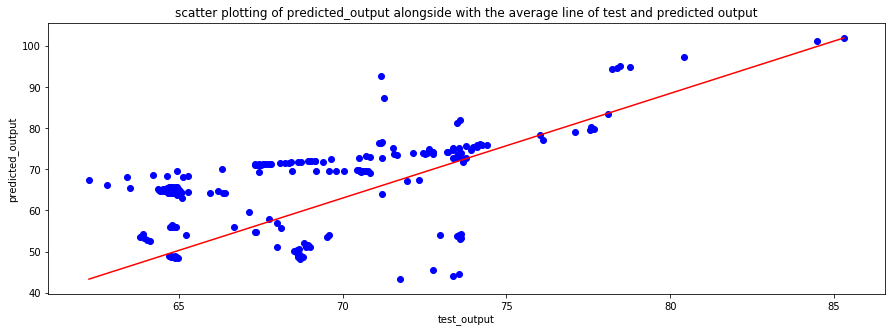

<class 'numpy.ndarray'>


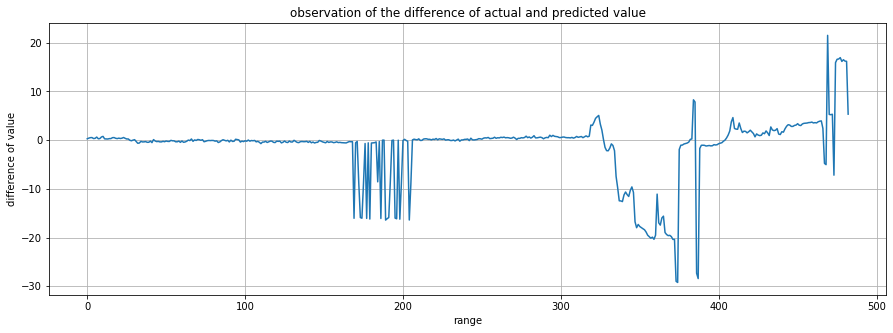

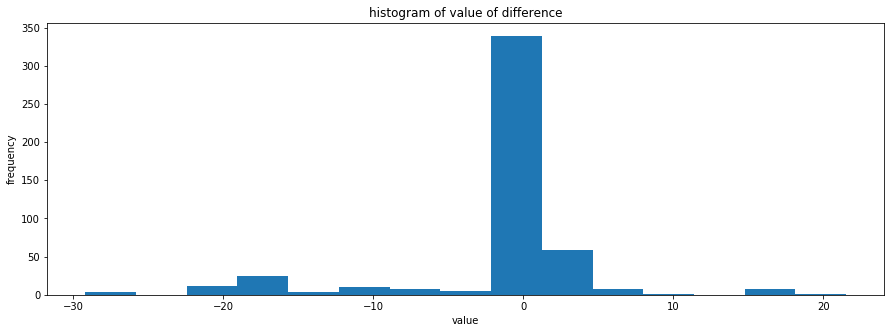

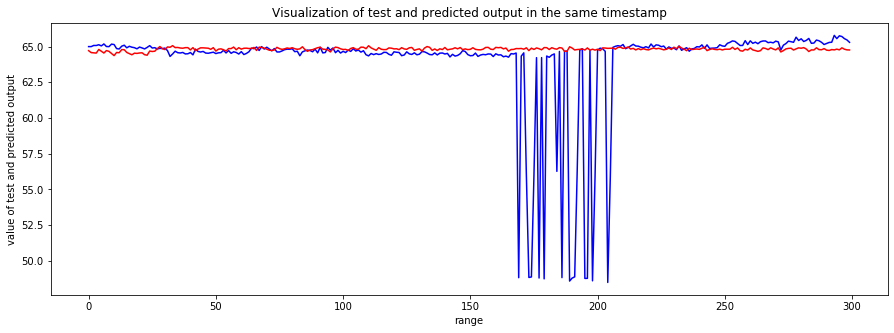

r_2 statistic: -2.46
Mean_absolute_error: 3.11
Mean squared error: 43.42
RMSE:  6.589211891041771
!!!!---------------!!!!----------------!!!!
------- ExtraTreesRegressor


/home/atif/iai_ml_venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


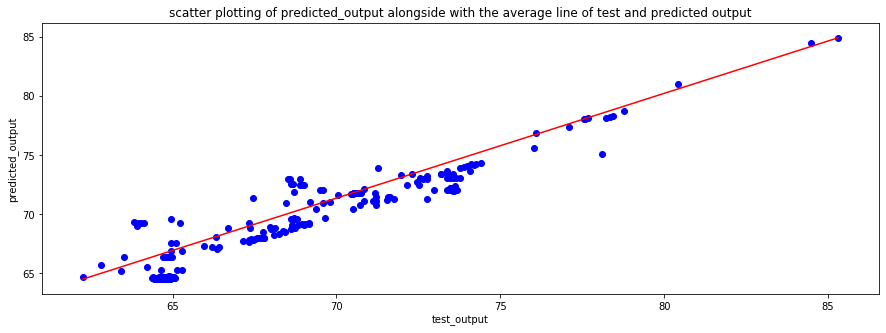

<class 'numpy.ndarray'>


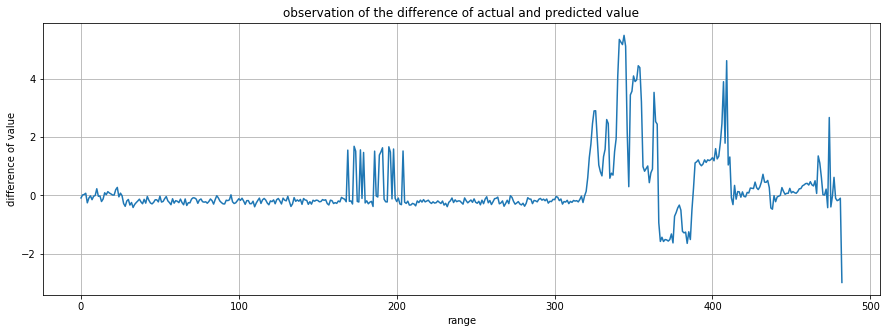

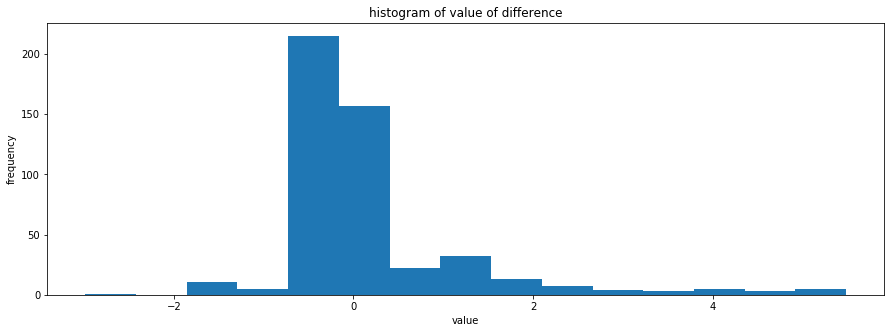

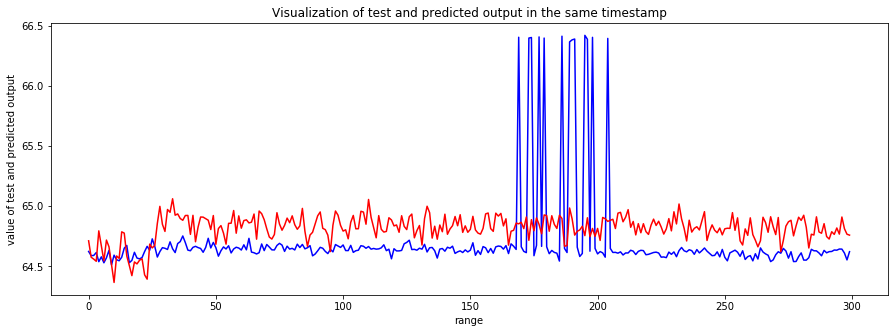

r_2 statistic: 0.91
Mean_absolute_error: 0.57
Mean squared error: 1.14
RMSE:  1.067796280158353
!!!!---------------!!!!----------------!!!!


In [63]:
model_list = [LinearRegression(), ExtraTreesRegressor()]
name = ['LinearRegression','ExtraTreesRegressor']

model_result = scikit_learn_model(model_list, name, train_input, train_output, test_input, test_output)

# Now dataframe for weekday, weekend, daywise, shiftwise will be made

In [58]:
# # checking type of the contect of the column
# s = df2['dateTime_column'].dtype
# print(s)

# # checking column type
# t = df2.dateTime_column
# print(type(t))

In [32]:
def dataframe_date_time_type(dataframe):
    df = pd.DataFrame(index = dataframe.index)
    target_df = dataframe.loc[:,dataframe.columns[-1]]
    df['dateTime_column'] =  pd.to_datetime(dataframe.index, format='%Y-%m-%d %H:%M')
    df['day_name'] = df.index.weekday_name
    df['TypeofDAY'] = np.where(df['dateTime_column'].dt.dayofweek < 5, 'Weekday', 'Weekend') # if the associated number less than 5 then weekend, otherwise weekday
    df['TypeofDAY_number'] = np.where(df['dateTime_column'].dt.dayofweek < 5, 1, 0) # 1 for weekday, 0 for weekend
    df['Date'] = df['dateTime_column'].dt.strftime('%Y-%m-%d')
    
    df = pd.concat([df, target_df], axis=1)
    
    return df

df = dataframe_date_time_type(dataframe_datetime)

In [33]:
dict_of_dates = {k: v for k, v in df.groupby('Date')}
dict_of_day_type = {k:v for k,v in df.groupby('TypeofDAY')}
dict_of_day_name = {k:v for k,v in df.groupby('day_name')}


date_key_value = collections.OrderedDict(dict_of_dates)
day_type_key_value = collections.OrderedDict(dict_of_day_type)
day_name_key_value = collections.OrderedDict(dict_of_day_name)

In [55]:
# for k_1 in day_type_key_value:
#     print(k_1)
#     my_week = dict_of_day_type[k_1]
#     my_week.iloc[:].plot(y=['AEWIHO_T9AV2'])
# #     describe = my_week['AEWIHO_T9AV2'].describe()
# #     RMSE = 2
# #     textstr = 'describe=%.2f\nRMSE=%.2f\n'%(1, 2)
# #     plt.text(0.5, 0.5, textstr, fontsize=14)
#     plt.savefig(str(k_1)+'.jpg')
# #     plt.close()

In [42]:
import os
current_directory = os.getcwd()
print(current_directory)
address = 'image_folder'
final_directory = current_directory+'/'+str(address)
if not os.path.exists(final_directory):
    os.makedirs(final_directory)
    print('created : ', final_directory)
else:
    pass
#     shutil.rmtree(final_directory,ignore_errors= True)
#     os.makedirs(final_directory)
#     print('after deletion old one created new : ', final_directory)

/home/atif/machine_learning_stuff/Time-Series-Forecasting-of-a-Power-Plant/univariate_data_for_prediction


In [43]:
final_directory

'/home/atif/machine_learning_stuff/Time-Series-Forecasting-of-a-Power-Plant/univariate_data_for_prediction/image_folder'

In [ ]:
import shutil
def draw_graph(dictionary_value, dictionary,target,path, subfolder_name):
    fig_location = path+'/'+str(subfolder_name)
    
    if not os.path.exists(fig_location):
        os.makedirs(fig_location)
    else:
        shutil.rmtree(fig_location,ignore_errors= True)
        os.makedirs(fig_location)
    for i in dictionary_value:
        value = dictionary[i]
        value.iloc[:].plot(y=[target])
        
        plt.title('visualization of signal '+str(target)+' in time of '+str(i))
        plt.xlabel('range')
        plt.ylabel('value')
        
        plt.rcParams['figure.figsize'] =(20,10)
        plt.savefig(fig_location+'/'+str(i)+'.jpg')
        
target = 'AEWIHO_T9AV2'
draw_graph_date = draw_graph(date_key_value,dict_of_dates, target,final_directory, subfolder_name = 'date_fig')
draw_graph_week = draw_graph(day_type_key_value,dict_of_day_type, target,final_directory, subfolder_name = 'week_fig')
draw_graph_day = draw_graph(day_name_key_value,dict_of_day_name, target,final_directory, subfolder_name = 'day_fig')